In [1]:
import os
os.environ["EPIONE_DATA_DIR"] = "/Users/fernandozeng/Desktop/analysis/25_epione/code/tutorial/genome"

import epione as epi
import snapatac2 as snap
import scanpy as sc
import matplotlib.pyplot as plt

epi.pl.plot_set()

%load_ext autoreload
%autoreload 2

└─ 🔬 Starting plot initialization...
  ├─ Apply Scanpy/matplotlib settings
  ├─ Custom font setup
  ├─ Suppress warnings
  ├─ 
___________      .__                      
\_   _____/_____ |__| ____   ____   ____  
 |    __)_\____ \|  |/  _ \ /    \_/ __ \ 
 |        \  |_> >  (  <_> )   |  \  ___/ 
/_______  /   __/|__|\____/|___|  /\___  >
        \/|__|                  \/     \/ 

  ├─ 🔖 Version: 0.0.1rc1   📚 Tutorials: https://epione.readthedocs.io/
└─ ✅ plot_set complete.



In [9]:
epi.pl.plot_set()

└─ 🔬 Starting plot initialization...
  ├─ Apply Scanpy/matplotlib settings
  ├─ Custom font setup
  ├─ Suppress warnings
└─ ✅ plot_set complete.



## Loading Data

We begin data preprocessing by importing fragment files and calculating basic quality control (QC) metrics using the pp.import_fragments() function.

This function compresses and stores the fragments in an AnnData object for later usage

In [2]:
adata=epi.pp.import_fragments(
    'data/scATAC_BMMC_R1.fragments.tsv.gz',
    chrom_sizes=epi.utils.genome.hg19,
    #file="pbmc.h5ad",  # Optional
    sorted_by_barcode=False,
)
adata

  └─ Added fragments file to adata.uns['files']


AnnData object with n_obs × n_vars = 5000 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences', 'files'
    obsm: 'fragment_paired'

In [3]:
adata.write('data/scATAC_BMMC_R1.h5ad')

## Quantity control

Fragment size distribution typically reflects nucleosome binding pattern showing enrichment around values corresponding to fragments bound to a single nucleosome (between 147 bp and 294 bp) as well as nucleosome-free fragments (shorter than 147 bp).

We first use pl.frag_size_distr() to calculate and plot the size distribution of fragments in this dataset. The typical fragment size distribution in ATAC-seq data exhibits several key characteristics

In [5]:
epi.pp.frag_size_distr(adata)
adata

└─ Computing fragment size distribution for adata...
  └─ Added fragment size distribution to adata.uns['frag_size_distr']


AnnData object with n_obs × n_vars = 5000 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences', 'files', 'frag_size_distr'
    obsm: 'fragment_paired'

(<Figure size 320x240 with 1 Axes>,
 <Axes: title={'center': 'Fragment size distribution'}, xlabel='Fragment size', ylabel='Count'>)

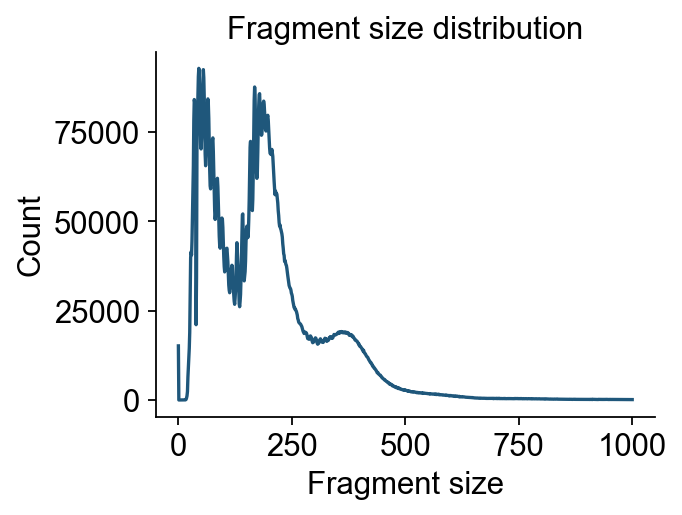

In [10]:
%matplotlib inline
epi.pl.frag_size_distr(
    adata,figsize=(4,3),
)

(<Figure size 320x240 with 1 Axes>,
 <Axes: title={'center': 'Fragment size distribution'}, xlabel='Fragment size', ylabel='Count'>)

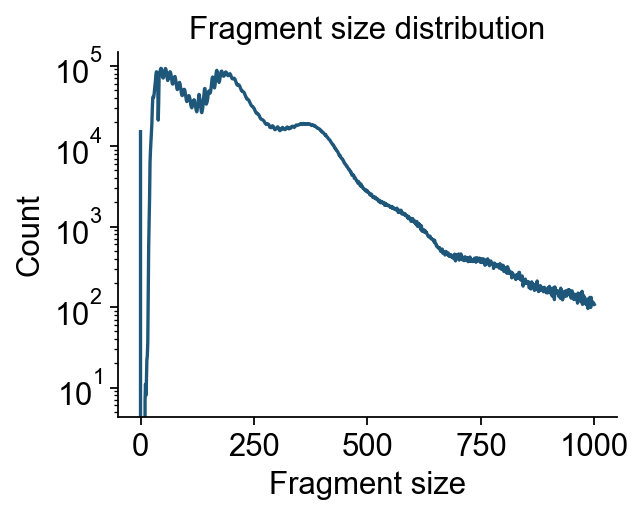

In [11]:
epi.pl.frag_size_distr(
    adata,figsize=(4,3),log_y=True
)

### Nucleosome signal

Next, we calculate scATAC specific QC metrics, the nucleosome signal and TTS enrichment score.

For the nucleosome signal, the default number of fragments n per cell used to calculate the metric is 10e4*n_cells. Since this takes long to calculate, we reduce it by a factor of 10, which still returns a good estimate. However, in a production pipeline we would still recommend to keep the default.

In [12]:
epi.pp.nucleosome_signal(
    adata,
    n=10e3 * adata.n_obs
)

└─ Computing nucleosome signal for adata...


Reading Fragments:  33%|████▎        | 16560340/50000000 [00:28<00:57, 576833.80it/s]

  └─ Added a "nucleosome_signal" column to the .obs slot of the AnnData object
└─ Created nucleosome signal
  └─ Added nucleosome signal to adata.obs['nucleosome_signal']


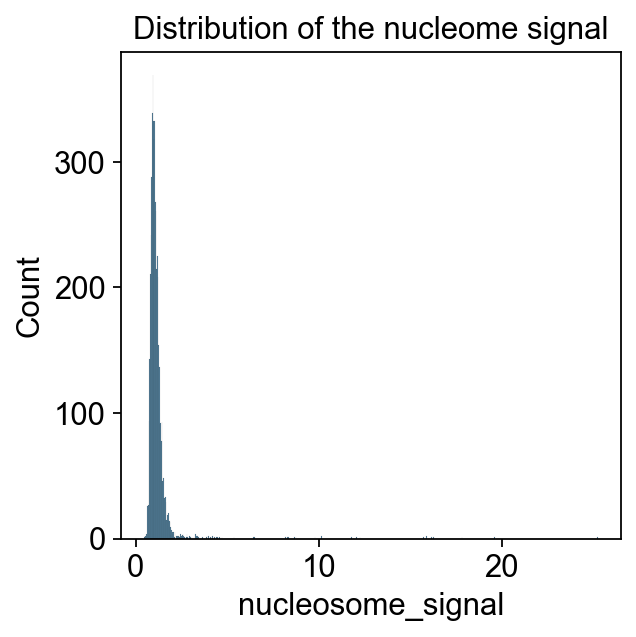

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(adata.obs, x="nucleosome_signal")
plt.title("Distribution of the nucleome signal")
plt.show()

# Alternatively as a violin plot (uncomment to plot)
# sc.pl.violin(atac, "nucleosome_signal")

The obtained scores in this data set range from 0 to 3. As a rule of thumb, previous analysis projects chose a threshold between 2 and 4 to label low quality cells. Let’s now take a closer look at cells with a high versus low nucleosome signal metric. To do so, we add a column to atac.obs, which contains a category for the two classes.

In [14]:
# Add group labels for above and below the nucleosome signal threshold
nuc_signal_threshold = 2
adata.obs["nuc_signal_filter"] = [
    "NS_FAIL" if ns > nuc_signal_threshold else "NS_PASS"
    for ns in adata.obs["nucleosome_signal"]
]

# Print number cells not passing nucleosome signal threshold
adata.obs["nuc_signal_filter"].value_counts()

nuc_signal_filter
NS_PASS    4894
NS_FAIL     106
Name: count, dtype: int64

We can see, this sample only contains 106 barcodes with a higher nucleosome signal than 2.

Next, we plot the distribution of fragment lengths per group of cells. To speed up the generation of the plotting, we analyze fragments mapping to a certain region on chromosome 1 by setting region="chr1:1-2000000"

Fetching Regions...: 100%|█████████████████████████████| 1/1 [00:00<00:00, 13.96it/s]


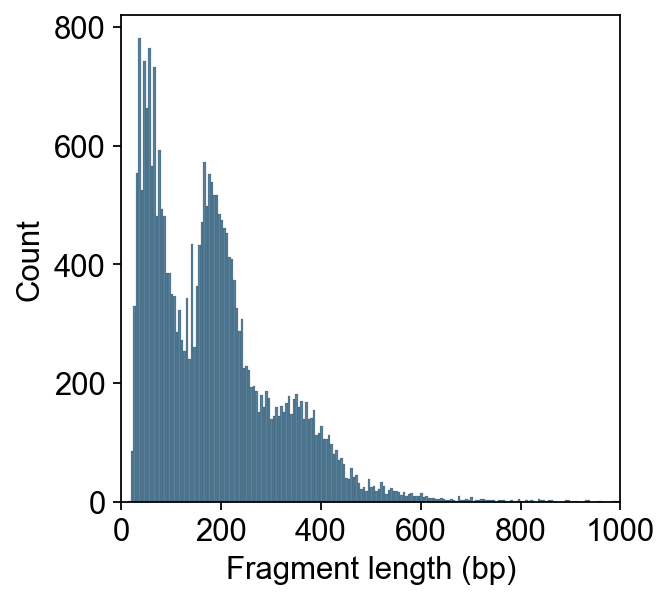

Fetching Regions...: 100%|█████████████████████████████| 1/1 [00:00<00:00, 14.13it/s]


<Axes: xlabel='Fragment length (bp)', ylabel='Count'>

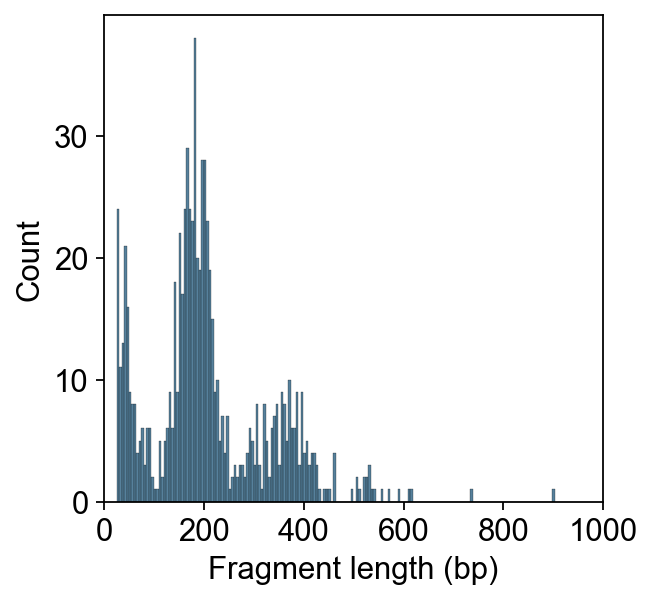

In [15]:
# Plot fragment size distribution
epi.pl.fragment_histogram(
    adata[adata.obs["nuc_signal_filter"] == "NS_PASS"], region="chr1:1-2000000",
    show=False,
)
plt.show()
epi.pl.fragment_histogram(
    adata[adata.obs["nuc_signal_filter"] == "NS_FAIL"], region="chr1:1-2000000",
    show=False,
)

### TSS enrichment

The next QC metric we assess is the signal-to-noise ratio in each cell. To do so, one can calculate the fraction of reads mapped to peak regions or the enrichment of fragments around transcription start sites (TSS). Here we use the later for assessing cell quality. To obtain a robust TSS score estimates while keeping compute time reasonably low, we set the number of randomly selected TSS to calculate the score to n_tss=100000.

In [16]:
features=epi.utils.read_features('genome/gencode.v41.basic.annotation.gtf.gz')
features.head()

└─ Reading features...
  └─ Reading GTF file from genome/gencode.v41.basic.annotation.gtf.gz...
  └─ GTF file read successfully
└─ Features read successfully


,seqname,source,feature,start,end,score,strand,frame,attribute,gene_id,transcript_id,gene_name,Chromosome,Start,End
0,chr1,HAVANA,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN...",ENSG00000223972.5,ENST00000456328.2,DDX11L1,chr1,11869,14409
1,chr1,HAVANA,transcript,12010,13670,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN...",ENSG00000223972.5,ENST00000450305.2,DDX11L1,chr1,12010,13670
2,chr1,HAVANA,transcript,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5""; transcript_id ""EN...",ENSG00000227232.5,ENST00000488147.1,WASH7P,chr1,14404,29570
4,chr1,HAVANA,transcript,29554,31097,.,+,.,"gene_id ""ENSG00000243485.5""; transcript_id ""EN...",ENSG00000243485.5,ENST00000473358.1,MIR1302-2HG,chr1,29554,31097
5,chr1,HAVANA,transcript,30267,31109,.,+,.,"gene_id ""ENSG00000243485.5""; transcript_id ""EN...",ENSG00000243485.5,ENST00000469289.1,MIR1302-2HG,chr1,30267,31109


In [17]:
tss=epi.pp.tss_enrichment(
    adata,
    features,
    n_tss=100000,
)

└─ Computing TSS enrichment score for adata...


Fetching Regions...: 100%|█████████████████| 100000/100000 [00:24<00:00, 4028.83it/s]


  └─ Added TSS enrichment score to adata.obs['tss_score']
└─ Created TSS enrichment score
  └─ Added TSS enrichment score to tss_pileup.obs['tss_score']
  └─ Returned TSS enrichment score


To understand the TSS score better, we plot the number of transposition events (fragment ends) up- and downstream of transcription start sites. We make use of the plotting function ac.pl.tss_enrichment available in muon and input the newly created tss object. To compare the enrichment profile corresponding to high and low TSS scores, we add a new column to tss.obs containing "TSS_PASS" or "TSS_FAIL" depending on a threshold that separates observations in the small peak of low scores we identified above.

In [18]:
tss_threshold = 1
tss.obs["tss_filter"] = [
    "TSS_FAIL" if score < tss_threshold else "TSS_PASS"
    for score in adata.obs["tss_score"]
]

# Print number cells not passing nucleosome signal threshold
tss.obs["tss_filter"].value_counts()

tss_filter
TSS_PASS    4450
TSS_FAIL     550
Name: count, dtype: int64

<Axes: title={'center': 'TSS Enrichment'}, xlabel='Distance from TSS, bp', ylabel='Average TSS enrichment score'>

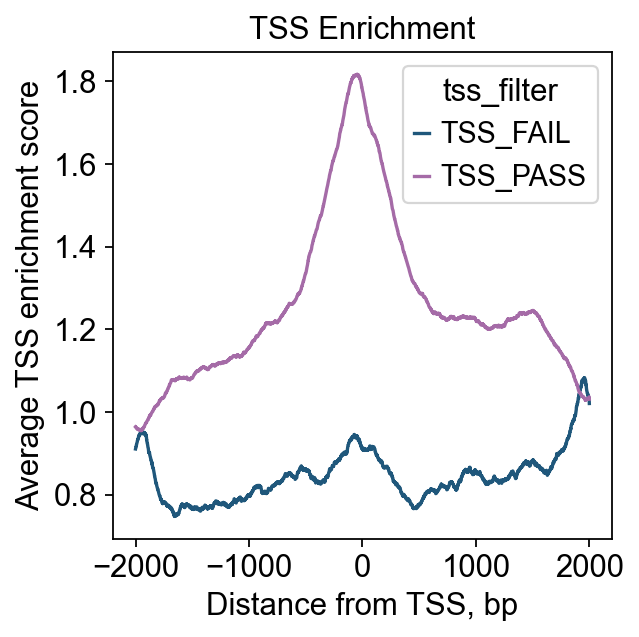

In [19]:
epi.pl.tss_enrichment(tss,color="tss_filter")

In [20]:
tss

AnnData object with n_obs × n_vars = 5000 × 4001
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'tss_filter'
    var: 'TSS_position'

btw, you can also you snapatac's tss enrichment function

In [21]:
epi.pp.tsse(adata, epi.utils.genome.hg19)

└─ Computing TSS enrichment score for adata...
  └─ Added TSS enrichment score to adata.obs['tsse']
  └─ Added library TSS enrichment score to adata.uns['library_tsse']
  └─ Added fraction of fragments overlapping TSS to adata.uns['frac_overlap_TSS']
  └─ Added TSS profile to adata.uns['TSS_profile']


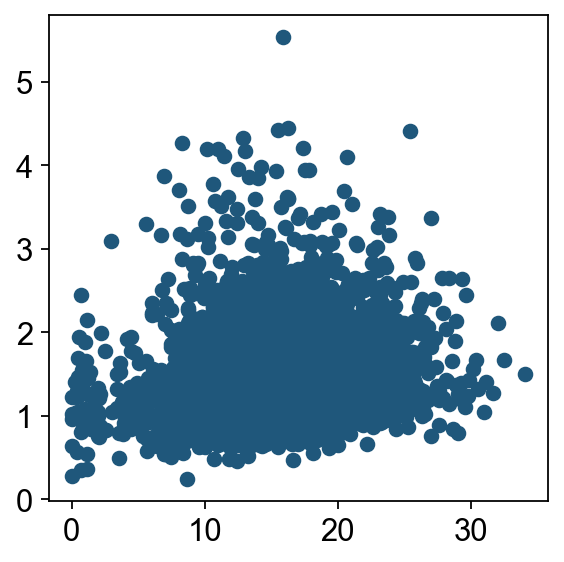

In [22]:
plt.scatter(
    adata.obs['tsse'],
    adata.obs['tss_score']
)

In [23]:
import numpy as np
adata.obs["log_total_fragment_counts"] = np.log10(adata.obs["n_fragment"])

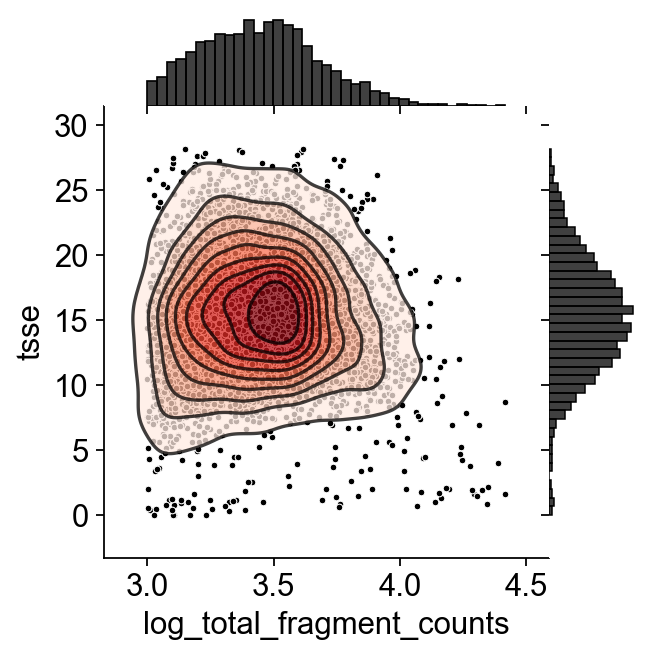

In [24]:
axes = epi.pl.plot_joint(
    adata,
    x_col='log_total_fragment_counts',
    y_col="tsse",               
    kde_kwargs={"cut": 3}      
)

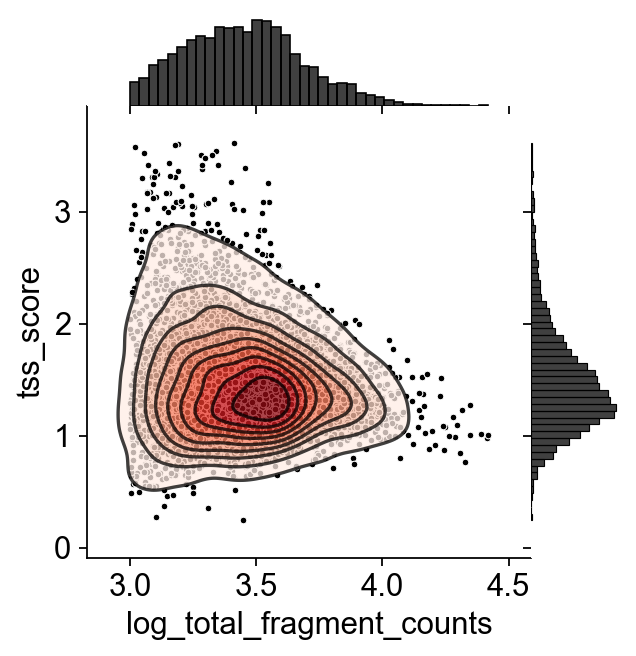

In [25]:
axes = epi.pl.plot_joint(
    adata,
    x_col='log_total_fragment_counts',
    y_col="tss_score",               
    kde_kwargs={"cut": 3}       
)

### One-step QC

In [26]:
adata=epi.pp.qc(
    adata,
    tresh={
        'fragment_counts_min': 2000,
        'fragment_counts_max': 100000,
        'TSS_score_min': 0.1,
        'TSS_score_max': 20,
        'Nucleosome_singal_max': 2,
    }
)
adata

└─ Performing QC...
  └─ Filtering cells based on fragment counts...
  └─ Filtering cells based on nucleosome signal...
  └─ Filtered 1525 cells


AnnData object with n_obs × n_vars = 3475 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'tsse', 'log_total_fragment_counts', 'selected'
    uns: 'reference_sequences', 'files', 'frag_size_distr', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

## Cell-Bin Matrix

We next create a cell by bin matrix containing insertion counts across genome-wide 500-bp bins.

In [27]:
epi.pp.add_tile_matrix(adata)
adata

└─ Generating cell by bin count matrix...
  └─ Added seqnames, start, end, and width to data.var


AnnData object with n_obs × n_vars = 3475 × 6155586
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'tsse', 'log_total_fragment_counts', 'selected'
    var: 'seqnames', 'start', 'end', 'width'
    uns: 'reference_sequences', 'files', 'frag_size_distr', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

Next, we perform feature selection using pp.select_features(). The result is stored in data.var['selected'] and will be automatically utilized by relevant functions such as pp.scrublet() and tl.spectral().

The default feature selection algorithm chooses the most accessible features. The n_features parameter determines the number of features or bins used in subsequent analysis steps. Generally, including more features improves resolution and reveals finer details, but it may also introduce noise. To optimize results, experiment with the n_features parameter to find the most appropriate value for your specific dataset.

In [28]:
epi.pp.select_features(
    adata,500000,
)

└─ Selected 500000 features.


## Doublet removal

Here we apply a customized scrublet algorithm to identify potential doublets. Calling pp.scrublet() will assign probabilites of being doublets to the cells.

In [29]:
epi.pp.scrublet(
    adata,
)

└─ Performing scrublet...
  └─ Simulating doublets...
  └─ Spectral embedding ...
  └─ Calculating doublet scores...
└─ Scrublet completed
  └─ Added doublet probability to adata.obs['doublet_probability']
  └─ Added doublet score to adata.obs['doublet_score']
  └─ Added scrublet simulation doublet score to adata.uns['scrublet_sim_doublet_score']
  └─ Ratio of doublets: 4.89%


In [30]:
adata

AnnData object with n_obs × n_vars = 3475 × 6155586
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'tsse', 'log_total_fragment_counts', 'selected', 'doublet_probability', 'doublet_score', 'is_doublet'
    var: 'seqnames', 'start', 'end', 'width', 'count', 'selected'
    uns: 'reference_sequences', 'files', 'frag_size_distr', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score'
    obsm: 'fragment_paired'

In [35]:
adata=adata[adata.obs['is_doublet']==False]
adata

View of AnnData object with n_obs × n_vars = 3305 × 6155586
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'tsse', 'log_total_fragment_counts', 'selected', 'doublet_probability', 'doublet_score', 'is_doublet'
    var: 'seqnames', 'start', 'end', 'width', 'count', 'selected'
    uns: 'reference_sequences', 'files', 'frag_size_distr', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score'
    obsm: 'fragment_paired'

## Cell-Peak Matrix
An important goal of single-cell ATAC-seq analysis is to identify genomic regions that are enriched with TN5 insertions, or “open chromatin” regions. Using tl.macs3(), we can easily identify “peaks” or open chromatin regions in different cell populations.

In the example below, we group the cells according to the “cell_type” label and then call peaks in each cell type. If you have replicate information and want to identify reproducible peaks across replicates, you can do this by specifying the replicate parameter.

In [36]:
%%time
snap.tl.macs3(adata, groupby=None)
adata

2025-09-12 14:09:11 - INFO - [2921 MB] #3 Pre-compute pvalue-qvalue table...
2025-09-12 14:10:11 - INFO - [2921 MB] #3 Call peaks for each chromosome...


CPU times: user 1min 45s, sys: 2.11 s, total: 1min 47s
Wall time: 1min 47s


AnnData object with n_obs × n_vars = 3305 × 6155586
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'tsse', 'log_total_fragment_counts', 'selected', 'doublet_probability', 'doublet_score', 'is_doublet'
    var: 'seqnames', 'start', 'end', 'width', 'count', 'selected'
    uns: 'reference_sequences', 'files', 'frag_size_distr', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score', 'macs3_pseudobulk'
    obsm: 'fragment_paired'

The result of this step is stored in adata.uns['macs3'] as a dictionary, where keys correspond to cell type labels, and values are identified peaks stored as a dataframe object.

The peaks called by MACS3 are usually with different length and peaks from different cell types may overlap. To facilitate the downstream analysis, a unified, non-overlapping, and fixed-width peak list is uaually desired. This can be acheived by the tl.merge_peaks() function.

In [39]:
epi.single.merge_peaks

<function epione.single._call_peaks.merge_peaks(peaks: "dict[str, 'polars.DataFrame']", chrom_sizes: 'dict[str, int] | Genome', half_width: 'int' = 250) -> "'polars.DataFrame'">

In [42]:
%%time
peaks = epi.utils.merge_peaks(adata.uns['macs3_pseudobulk'], epi.utils.hg19)
peaks.head()

CPU times: user 143 ms, sys: 22.1 ms, total: 165 ms
Wall time: 175 ms


Peaks,sample0
str,bool
"""chr1:569155-569656""",true
"""chr1:713867-714368""",true
"""chr1:752495-752996""",true
"""chr1:762671-763172""",true
"""chr1:779824-780325""",true



  8%|██▉                                   | 72.2M/949M [00:19<01:01, 14.2MB/s]

In [44]:
%%time
peak_mat = epi.pp.make_peak_matrix(adata, use_rep=peaks['Peaks'])
peak_mat

CPU times: user 5.45 s, sys: 265 ms, total: 5.72 s
Wall time: 1.11 s


AnnData object with n_obs × n_vars = 3305 × 103521
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'tsse', 'log_total_fragment_counts', 'selected', 'doublet_probability', 'doublet_score', 'is_doublet'

## Dimension reduction

### Latent semantic indexing (LSI)

Epione implements a few different LSI implementations and we have benchmarked many of these methods across multiple different test data sets. Epione’s default LSI implementation is related to the method introduced by Timothy Stuart in Signac, which uses a term frequency that has been depth normalized to a constant (10,000) followed by normalization with the inverse document frequency and then log-transforming the resultant matrix (aka log(TF-IDF)).

In [45]:
epi.pp.select_features(
    peak_mat,10000,
)

└─ Selected 10000 features.


In [49]:
peak_mat_test=peak_mat[:,peak_mat.var['selected']]
peak_mat_test

View of AnnData object with n_obs × n_vars = 3305 × 10000
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'tsse', 'log_total_fragment_counts', 'selected', 'doublet_probability', 'doublet_score', 'is_doublet'
    var: 'count', 'selected'

In [54]:
epi.tl.lsi(
    peak_mat,
    n_components=100
)

  └─ Starting optimized LSI analysis...
  └─ Computing TF-IDF normalization...
  └─ Applying L1 normalization and log transformation...
  └─ Performing randomized SVD...
  └─ Standardizing embeddings...
  └─ Removing first component (typically associated with peak count per cell)
  └─ LSI analysis completed!


In [55]:
import scanpy as sc
sc.pp.neighbors(peak_mat, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.tl.umap(peak_mat)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)


... storing 'nuc_signal_filter' as categorical


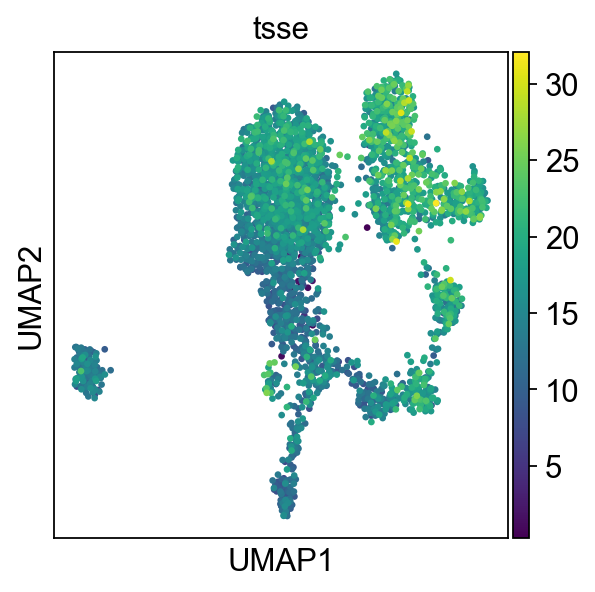

In [57]:
sc.pl.umap(
    peak_mat,
    color='tsse'
)

### Spectral

Convert the cell-by-feature count matrix into lower dimensional representations using the spectrum of the normalized graph Laplacian defined by pairwise similarity between cells. This function utilizes the matrix-free spectral embedding algorithm to compute the embedding when distance_metric is “cosine”, which scales linearly with the number of cells. For other types of similarity metrics, the time and space complexity scale quadratically with the number of cells.

In [59]:
%%time
snap.tl.spectral(peak_mat)

CPU times: user 1.02 s, sys: 45.1 ms, total: 1.06 s
Wall time: 1.07 s


In [61]:
import scanpy as sc
sc.pp.neighbors(peak_mat, use_rep="X_spectral", n_neighbors=10)
sc.tl.umap(peak_mat)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)


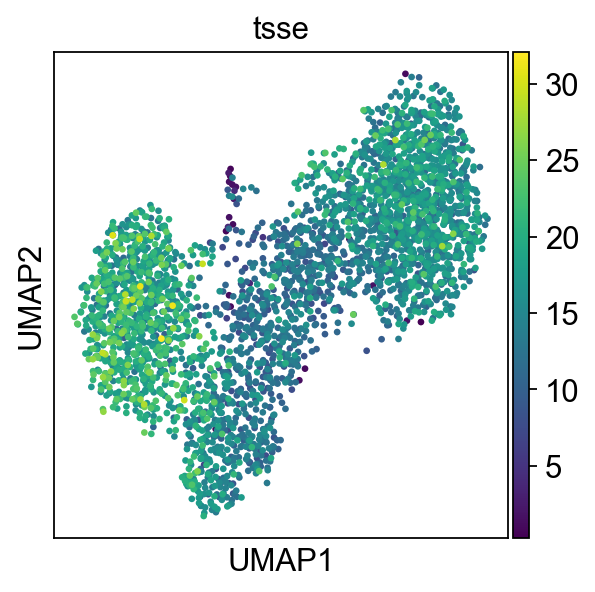

In [62]:
sc.pl.umap(
    peak_mat,
    color='tsse'
)